In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simple_moving_average(df, column, window):
    df[f'{column}_SMA_{window}'] = df[column].rolling(window=window).mean()
    return df

# Пример использования:
# df = simple_moving_average(df, 'sales', window=3)


def weighted_moving_average(df, column, window):
    weights = np.arange(1, window + 1)  # Веса от 1 до размера окна
    wma = df[column].rolling(window).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
    df[f'{column}_WMA_{window}'] = wma
    return df

# Пример использования:
# df = weighted_moving_average(df, 'sales', window=3)

def exponential_moving_average(df, column, span):
    df[f'{column}_EMA_{span}'] = df[column].ewm(span=span, adjust=False).mean()
    return df

# Пример использования:
# df = exponential_moving_average(df, 'sales', span=3)

def line_plot_with_legend(df, variables):
    # Построение линий для каждой переменной
    plt.figure(figsize=(10, 6))
    
    for var in variables:
        sns.lineplot(data=df, x=df.index, y=var, label=var)
    
    # Подписи осей
    plt.xlabel('Index')
    plt.ylabel('Values')
    
    # Добавляем легенду
    plt.legend(title="Variables")
    
    # Отображаем график
    plt.tight_layout()
    plt.show()

import pandas as pd

def calculate_mape(df, target_col, predictions_list, add=1e-10):
    """
    Рассчитывает MAPE для нескольких прогнозов по отношению к таргету.
    
    Параметры:
    - df: DataFrame с данными.
    - target_col: колонка с истинными значениями (таргет).
    - predictions_list: список названий столбцов с прогнозами.
    - add: значение, добавляемое к таргету для избежания деления на ноль.
    
    Возвращает:
    - DataFrame с названиями предсказаний и их значениями MAPE.
    """
    
    # Проверка, что таргет и прогнозы есть в DataFrame
    if target_col not in df.columns:
        raise ValueError(f"Колонка с таргетом '{target_col}' не найдена в DataFrame.")
    
    missing_predictions = [pred for pred in predictions_list if pred not in df.columns]
    if missing_predictions:
        raise ValueError(f"Прогнозы {missing_predictions} не найдены в DataFrame.")
    
    # Список для хранения MAPE для каждого прогноза
    mape_results = []
    
    # Рассчет MAPE для каждого прогноза
    for pred_col in predictions_list:
        # MAPE = (1/n) * sum(|(y_true - y_pred)| / (y_true + add)) * 100
        mape = (abs(df[target_col] - df[pred_col]) / (df[target_col] + add)).mean() * 100
        mape_results.append({'Prediction': pred_col, 'MAPE': mape})
    
    # Возвращаем результаты в виде DataFrame
    return pd.DataFrame(mape_results)


In [3]:
shop_sales = pd.read_csv('shop_sales.csv')
shop_sales_dates = pd.read_csv('shop_sales_dates.csv')
shop_sales_prices = pd.read_csv('shop_sales_prices.csv')

In [4]:
def create_lag_features(df, feature_list, min_lag, max_lag):
    """
    Создает лаговые признаки
    Параметры:
    - df: DataFrame с исходными данными.
    - feature_list: список колонок, для которых создаются лаги.
    - min_lag: минимальный лаг.
    - max_lag: максимальный лаг.
    
    Возвращает:
    - DataFrame, содержащий лаги для указанных фичей.
    """
    lagged_df = pd.concat(
        [df[feature_list].shift(lag).add_suffix(f'_lag_{lag}') for lag in range(min_lag, max_lag + 1)], 
        axis=1
    )
    
    return lagged_df

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_simple_time_series(df, date_col, value_col, title="Time Series", xlabel="Date", ylabel="Value", figsize=(10, 5)):
    plt.figure(figsize=figsize)
    sns.lineplot(data=df, x=date_col, y=value_col)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Пример использования:
# plot_simple_time_series(df, 'date', 'sales')

In [6]:
# пример для одного sku
id = 'STORE_2_085'

In [7]:
# присоединяем даты и фичи из dates
shop_sales_with_dates = pd.merge(shop_sales[shop_sales['item_id'] == id], shop_sales_dates, on = 'date_id')

In [8]:
# присоединяем цены
data_p = pd.merge(shop_sales_with_dates, shop_sales_prices[shop_sales_prices['item_id'] == id], on = ['wm_yr_wk'], how= 'left')

In [9]:
## заполняем миссинги по цене если они есть
data_p['sell_price'] = data_p['sell_price'].ffill().bfill()

In [10]:
# создаем лаги для фичей от 1 до 3 + скользящие средние лаг 1 (поскольку предсказываем на 1 шаг) для окна 3

df = simple_moving_average(data_p, 'cnt', 3)
df = weighted_moving_average(data_p, 'cnt', 3)
df = exponential_moving_average(data_p, 'cnt', 3)

In [11]:
df.head(3)

,item_id_x,store_id_x,date_id,cnt,date,wm_yr_wk,weekday,wday,month,year,...,event_type_2,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,store_id_y,item_id_y,sell_price,cnt_SMA_3,cnt_WMA_3,cnt_EMA_3
0,STORE_2_085,STORE_2,1,3,2011-01-29,11101,Saturday,1,1,2011,...,NaN,0,0,0,STORE_2,STORE_2_085,1.0,NaN,NaN,3.00
1,STORE_2_085,STORE_2,2,8,2011-01-30,11101,Sunday,2,1,2011,...,NaN,0,0,0,STORE_2,STORE_2_085,1.0,NaN,NaN,5.50
2,STORE_2_085,STORE_2,3,0,2011-01-31,11101,Monday,3,1,2011,...,NaN,0,0,0,STORE_2,STORE_2_085,1.0,3.666667,3.166667,2.75


In [12]:
shop_sales[shop_sales['item_id'] == id]

,item_id,store_id,date_id,cnt
0,STORE_2_085,STORE_2,1,3
1,STORE_2_085,STORE_2,2,8
2,STORE_2_085,STORE_2,3,0
3,STORE_2_085,STORE_2,4,3
4,STORE_2_085,STORE_2,5,0
...,...,...,...,...
1814,STORE_2_085,STORE_2,1815,10
1815,STORE_2_085,STORE_2,1816,3
1816,STORE_2_085,STORE_2,1817,3
1817,STORE_2_085,STORE_2,1818,15


In [13]:
list_for_lags = ['wday','month','CASHBACK_STORE_1','CASHBACK_STORE_2','CASHBACK_STORE_3','sell_price','cnt_SMA_3','cnt_WMA_3','cnt_EMA_3', 'cnt']

In [14]:
df[list_for_lags]

,wday,month,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,sell_price,cnt_SMA_3,cnt_WMA_3,cnt_EMA_3,cnt
0,1,1,0,0,0,1.00,NaN,NaN,3.000000,3
1,2,1,0,0,0,1.00,NaN,NaN,5.500000,8
2,3,1,0,0,0,1.00,3.666667,3.166667,2.750000,0
3,4,2,0,1,1,1.00,3.666667,2.833333,2.875000,3
4,5,2,1,1,0,1.00,1.000000,1.000000,1.437500,0
...,...,...,...,...,...,...,...,...,...,...
1814,2,1,0,0,0,0.98,7.666667,8.000000,7.961636,10
1815,3,1,0,0,0,0.98,6.000000,5.666667,5.480818,3
1816,4,1,0,0,0,0.98,5.333333,4.166667,4.240409,3
1817,5,1,0,0,0,0.98,7.000000,9.000000,9.620205,15


In [15]:
X = create_lag_features(df, list_for_lags, 1, 3)

In [16]:
# добавим дату
X['date'] = df['date']

In [17]:
y = df['cnt'] + 1 # чтобы убрать нули, иначе MAPE улетит в космос. Далее вычтем 1 для прогноза

In [18]:
## моделируем 

from Tools import *

In [19]:
# Задаем значение для генератора случайных чисел
seed_value = 23
np.random.seed(seed_value)

In [20]:
X['date'] = pd.to_datetime(X['date'])

In [21]:
# creating cross validator
cv_datetime = DateTimeSeriesSplit(window = 365, n_splits= 4, test_size = 30, margin=0)
group_dt = X['date']

## get parametres from train and test for each fold
for fold, (train_idx, val_idx) in enumerate(cv_datetime.split(X, groups=group_dt), 1):
    print(fold)
    train, test = X.iloc[train_idx], X.iloc[val_idx]
    print(f'треин мин {train.date.min()} треин макс {train.date.max()} shape {train.shape}')
    print(f'тест мин {test.date.min()} тест макс {test.date.max()} shape {test.shape}')

1
треин мин 2014-09-24 00:00:00 треин макс 2015-09-23 00:00:00 shape (365, 32)
тест мин 2015-09-24 00:00:00 тест макс 2015-10-23 00:00:00 shape (30, 32)
2
треин мин 2014-10-24 00:00:00 треин макс 2015-10-23 00:00:00 shape (365, 32)
тест мин 2015-10-24 00:00:00 тест макс 2015-11-22 00:00:00 shape (30, 32)
3
треин мин 2014-11-23 00:00:00 треин макс 2015-11-22 00:00:00 shape (365, 32)
тест мин 2015-11-23 00:00:00 тест макс 2015-12-22 00:00:00 shape (30, 32)
4
треин мин 2014-12-23 00:00:00 треин макс 2015-12-22 00:00:00 shape (365, 32)
тест мин 2015-12-23 00:00:00 тест макс 2016-01-21 00:00:00 shape (30, 32)


In [22]:
features = [i for i in X.columns]
features.remove('date')
features.remove('index_time')

In [23]:
features

['wday_lag_1',
 'month_lag_1',
 'CASHBACK_STORE_1_lag_1',
 'CASHBACK_STORE_2_lag_1',
 'CASHBACK_STORE_3_lag_1',
 'sell_price_lag_1',
 'cnt_SMA_3_lag_1',
 'cnt_WMA_3_lag_1',
 'cnt_EMA_3_lag_1',
 'cnt_lag_1',
 'wday_lag_2',
 'month_lag_2',
 'CASHBACK_STORE_1_lag_2',
 'CASHBACK_STORE_2_lag_2',
 'CASHBACK_STORE_3_lag_2',
 'sell_price_lag_2',
 'cnt_SMA_3_lag_2',
 'cnt_WMA_3_lag_2',
 'cnt_EMA_3_lag_2',
 'cnt_lag_2',
 'wday_lag_3',
 'month_lag_3',
 'CASHBACK_STORE_1_lag_3',
 'CASHBACK_STORE_2_lag_3',
 'CASHBACK_STORE_3_lag_3',
 'sell_price_lag_3',
 'cnt_SMA_3_lag_3',
 'cnt_WMA_3_lag_3',
 'cnt_EMA_3_lag_3',
 'cnt_lag_3']

In [24]:
# create model for selector
from lightgbm import LGBMRegressor
model = LGBMRegressor(max_depth=3, verbosity = -1)

# create list from which we will take vars for model creating
list_of_vars = features.copy()

In [25]:
# import metrics for var selection
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# create selector
selector1 = Kraken(model, cv_datetime, MAPE, 'exp1')

In [26]:
# get rank dict from vars
selector1.get_rank_dict(X, y, list_of_vars, group_dt)
 
# get ranked dict in descending order of abs shap value (самые сильные фичи по убыванию предсказательной силы)
selector1.rank_dict

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\vitya\OneDrive\Рабочий стол\venvs\hardml\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


{'cnt_EMA_3_lag_1': 1,
 'cnt_EMA_3_lag_3': 2,
 'cnt_SMA_3_lag_3': 3,
 'wday_lag_2': 4,
 'month_lag_3': 5,
 'cnt_WMA_3_lag_1': 6,
 'wday_lag_1': 7,
 'cnt_WMA_3_lag_3': 8,
 'cnt_SMA_3_lag_2': 9,
 'cnt_SMA_3_lag_1': 10,
 'month_lag_1': 11,
 'cnt_EMA_3_lag_2': 12,
 'cnt_lag_3': 13,
 'cnt_lag_1': 14,
 'cnt_WMA_3_lag_2': 15,
 'wday_lag_3': 16,
 'month_lag_2': 17,
 'cnt_lag_2': 18,
 'CASHBACK_STORE_3_lag_3': 19,
 'CASHBACK_STORE_1_lag_2': 20,
 'CASHBACK_STORE_3_lag_2': 21,
 'CASHBACK_STORE_1_lag_1': 22,
 'CASHBACK_STORE_2_lag_2': 23,
 'CASHBACK_STORE_1_lag_3': 24,
 'CASHBACK_STORE_2_lag_1': 25,
 'CASHBACK_STORE_2_lag_3': 26,
 'CASHBACK_STORE_3_lag_1': 27,
 'sell_price_lag_1': 28,
 'sell_price_lag_2': 29,
 'sell_price_lag_3': 30}

In [27]:
## get vars
vars_final = selector1.get_vars(X, y, early_stopping_rounds = 30, group_dt = group_dt); vars_final

запуск первого шага
new var_for_add ! cnt_EMA_3_lag_1
new var_for_add ! wday_lag_2
едем дальше
в итоге получили список ['wday_lag_2']
запуск первого шага
new var_for_add ! CASHBACK_STORE_2_lag_3
едем дальше
в итоге получили список ['wday_lag_2', 'CASHBACK_STORE_2_lag_3']
запуск первого шага
new var_for_add ! wday_lag_1
едем дальше
в итоге получили список ['wday_lag_2', 'CASHBACK_STORE_2_lag_3', 'wday_lag_1']
запуск первого шага
new var_for_add ! CASHBACK_STORE_2_lag_2
едем дальше
в итоге получили список ['wday_lag_2', 'CASHBACK_STORE_2_lag_3', 'wday_lag_1', 'CASHBACK_STORE_2_lag_2']
запуск первого шага
new var_for_add ! wday_lag_3
едем дальше
в итоге получили список ['wday_lag_2', 'CASHBACK_STORE_2_lag_3', 'wday_lag_1', 'CASHBACK_STORE_2_lag_2', 'wday_lag_3']
запуск первого шага
new var_for_add ! CASHBACK_STORE_2_lag_1
едем дальше
в итоге получили список ['wday_lag_2', 'CASHBACK_STORE_2_lag_3', 'wday_lag_1', 'CASHBACK_STORE_2_lag_2', 'wday_lag_3', 'CASHBACK_STORE_2_lag_1']
запуск перво

['wday_lag_2',
 'CASHBACK_STORE_2_lag_3',
 'wday_lag_1',
 'CASHBACK_STORE_2_lag_2',
 'wday_lag_3',
 'CASHBACK_STORE_2_lag_1']

In [28]:
# обучим базовую модель на полученных фичах
# для обучения возьмем последние - 30 дней данные, для сравнения с базовыми моделями - последние 30 дней
# метрика MAPE

df['date_id'].max()

1819

In [29]:
X_train = X[df['date_id'] < df['date_id'].max() - 30]
y_train = df[df['date_id'] < df['date_id'].max() - 30]['cnt']

# oot - out of time
X_oot = X[df['date_id'] >= df['date_id'].max() - 30]
y_oot = df[df['date_id'] >= df['date_id'].max() - 30]['cnt']

In [30]:
print(X_train.date.max(), X_oot.date.max())

2015-12-21 00:00:00 2016-01-21 00:00:00


In [31]:
model.fit(X_train[vars_final], y_train)

LGBMRegressor(max_depth=3, verbosity=-1)

In [32]:
X_oot['pred'] = model.predict(X_oot[vars_final]) - 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


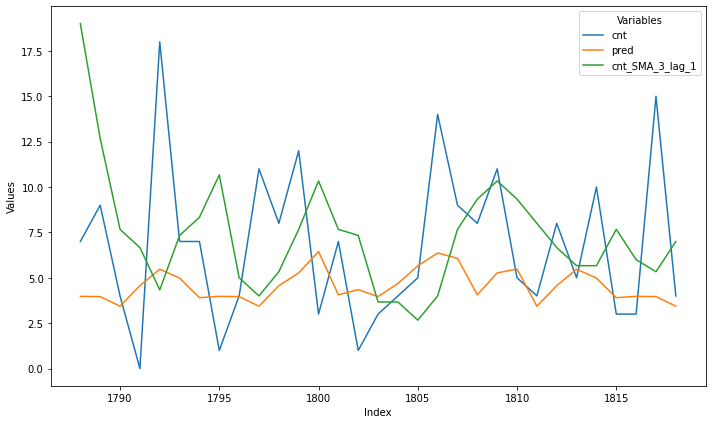

In [33]:

# Вызов функции для построения линий с легендой
line_plot_with_legend(pd.concat([y_oot,X_oot], axis = 1), variables=['cnt', 'pred', 'cnt_SMA_3_lag_1'])

In [34]:
# возьмем рандомные 100 строк и сделаем среднюю нашим константным прогнозом
X_oot['constant'] = df.sample(100)['cnt'].mean()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
result = calculate_mape(pd.concat([y_oot,X_oot], axis = 1), target_col='cnt', predictions_list=['pred', 'cnt_SMA_3_lag_1', 'cnt_lag_1', 'constant'], add= 1)
result

,Prediction,MAPE
0,pred,56.047895
1,cnt_SMA_3_lag_1,91.761639
2,cnt_lag_1,89.430629
3,constant,63.280104
